In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

class Autoencoder2(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.Tanh(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.Tanh(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.Tanh(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.Tanh(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

class Autoencoder3(nn.Module):
    def __init__(self):
        super().__init__()
        # Codificador
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            self.pool1,                               # -> N, 16, 7, 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 4, 4
            nn.ReLU(),
            self.pool2,                               # -> N, 32, 2, 2
            nn.Conv2d(32, 64, 2)                      # -> N, 64, 1, 1
        )
        
        # Decodificador
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2),            # -> N, 32, 2, 2
            self.unpool2,                             # -> N, 32, 4, 4
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> N, 16, 7, 7
            self.unpool1,                             # -> N, 16, 14, 14
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        # Codificación con índices
        x = self.encoder[0](x)  # Conv2D
        x = self.encoder[1](x)  # ReLU
        x, idx1 = self.pool1(x)  # MaxPool2D con índices
        x = self.encoder[3](x)  # Conv2D
        x = self.encoder[4](x)  # ReLU
        x, idx2 = self.pool2(x)  # MaxPool2D con índices
        x = self.encoder[6](x)  # Conv2D final
        
        # Decodificación usando los índices
        x = self.decoder[0](x)  # ConvTranspose2D
        x = self.unpool2(x, idx2)  # MaxUnpool2D
        x = self.decoder[2](x)  # ConvTranspose2D
        x = self.unpool1(x, idx1)  # MaxUnpool2D
        x = self.decoder[4](x)  # ConvTranspose2D final
        return x

    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh



class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> N, 16, 14, 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 7, 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 7)  # -> N, 128, 1, 1
        )
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),  # Flatten -> N, 128
            nn.Linear(128, 32)  # Bottleneck -> N, 32
        )

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(32, 128),  # Expand -> N, 128
            nn.Unflatten(1, (128, 1, 1))  # Reshape to 2D -> N, 128, 1, 1
        )
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7),  # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        encoded = self.encoder_cnn(x)
        encoded = self.encoder_fc(encoded)
        # Decoding
        decoded = self.decoder_fc(encoded)
        decoded = self.decoder_cnn(decoded)
        return decoded



In [6]:
model = Autoencoder()
#model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0088
Epoch:2, Loss:0.0049
Epoch:3, Loss:0.0044
Epoch:4, Loss:0.0032
Epoch:5, Loss:0.0033
Epoch:6, Loss:0.0030
Epoch:7, Loss:0.0031
Epoch:8, Loss:0.0032
Epoch:9, Loss:0.0026
Epoch:10, Loss:0.0024


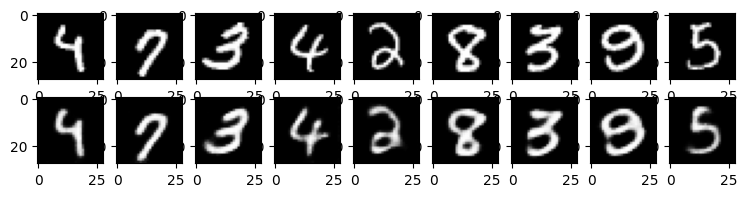

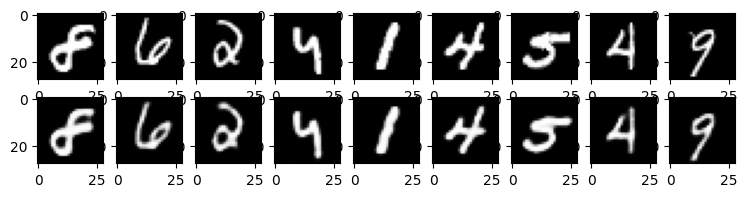

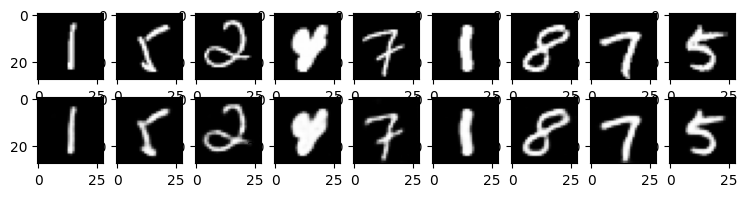

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

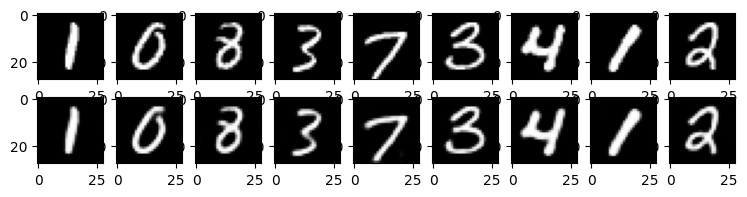

In [9]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        #img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        #pred = model(img2)
        pred = model(img)
        recon = pred[0].detach().numpy()
        #recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        #plt.imshow(recon2[0])
        plt.imshow(recon)


### Ejercicios

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.



In [10]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

Buscamos los mejores hiperparámetros para 10 épocas:

In [12]:
from itertools import product

# Definir los hiperparámetros a explorar
learning_rates = [1e-2, 1e-3, 1e-4]
noise_factors = [0.5,0.7,0.9]
weight_decays = [1e-5, 1e-4, 1e-3]
num_epochs = 10

# Guardar resultados
results = []

# Búsqueda en el espacio de hiperparámetros
for lr, noise_factor, wd in product(learning_rates, noise_factors, weight_decays):
    print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={wd}")
    
    model = Autoencoder()  # Cambia si quieres probar con Autoencoder2 o Autoencoder3
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Entrenamiento
    for epoch in range(num_epochs):
        epoch_loss = 0
        for (img, _) in data_loader:
            noisy_image = add_noise(img, noise_factor=noise_factor)
            recon = model(noisy_image)
            loss = criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_loss /= len(data_loader)  # Promedio por batch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    # Guardar el resultado final
    results.append({
        "lr": lr,
        "noise_factor": noise_factor,
        "weight_decay": wd,
        "final_loss": epoch_loss
    })

# Ordenar los resultados por la menor pérdida final
best_params = sorted(results, key=lambda x: x['final_loss'])[0]
print(f"Best Parameters: {best_params}")


Training with lr=0.01, noise_factor=0.5, weight_decay=1e-05
Epoch 1/10, Loss: 0.0443
Epoch 2/10, Loss: 0.0182
Epoch 3/10, Loss: 0.0157
Epoch 4/10, Loss: 0.0151
Epoch 5/10, Loss: 0.0147
Epoch 6/10, Loss: 0.0147
Epoch 7/10, Loss: 0.0145
Epoch 8/10, Loss: 0.0145
Epoch 9/10, Loss: 0.0144
Epoch 10/10, Loss: 0.0144
Training with lr=0.01, noise_factor=0.5, weight_decay=0.0001
Epoch 1/10, Loss: 0.0333
Epoch 2/10, Loss: 0.0191
Epoch 3/10, Loss: 0.0184
Epoch 4/10, Loss: 0.0180
Epoch 5/10, Loss: 0.0180
Epoch 6/10, Loss: 0.0179
Epoch 7/10, Loss: 0.0179
Epoch 8/10, Loss: 0.0179
Epoch 9/10, Loss: 0.0179


KeyboardInterrupt: 

In [ ]:
# Crear un diccionario para almacenar los mejores resultados por noise_factor
best_params_per_noise = {}

# Agrupar los resultados por noise_factor
for noise_factor in set([res["noise_factor"] for res in results]):
    # Filtrar resultados para este noise_factor
    noise_results = [res for res in results if res["noise_factor"] == noise_factor]
    # Ordenar por final_loss y tomar el mejor
    best_params = sorted(noise_results, key=lambda x: x["final_loss"])[0]
    best_params_per_noise[noise_factor] = best_params

# Mostrar los mejores resultados por noise_factor
for noise_factor, params in best_params_per_noise.items():
    print(f"Noise Factor: {noise_factor}, Best Params: {params}")


Entonces, tomamos como mejores hiperparámetros lr=0.001 y weight_decay= 1e-05

### Ejercicios

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.

